## A few notes if you are running with AWS free tier:
    
1. check the doc here to make sure you only used the services (especially instance) covered by AWS free tier
2. Dont repeat the data generation process, as S3 charged by the number of read/write.
3. You can start with a much smaller set of users by set NUM_USERS = 100

In [2]:
# config file
my_prefix_ipinsight = "sagemaker/ipinsights-tutorial-bwx"

prefix = my_prefix_ipinsight

In [3]:
import pandas as pd
import boto3
import io
import botocore
import os
import sagemaker

# setting for S3 connection 

bucket = sagemaker.Session().default_bucket()
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name
prefix = prefix
s3_client = boto3.client('s3')

In [4]:
def load_data_s3(bucket, prefix, subdir, data_file, cols ):
    """ load data as pandas DataFrame from S3 
    """
    file_key = os.path.join(prefix, subdir, data_file)
    obj = s3_client.get_object(Bucket=bucket, Key=file_key)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), names = cols)
    return df 

## Load Model From S3 and Deploy to Endpoint for Inference

In [5]:
model_file = "output/ipinsights-220102-0319-003-80770fd8/output/model.tar.gz"

In [6]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image = get_image_uri(boto3.Session().region_name, "ipinsights")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [7]:
from sagemaker.tensorflow.model import TensorFlowModel

ip_model_v2 = TensorFlowModel(
    model_data = f"s3://{bucket}/{prefix}/{model_file}",
    image_uri=image,  
    role=execution_role)  

In [8]:
# predictor = ip_insights.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")
predictor = ip_model_v2.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------!

### Data Serialization/Deserialization
We can pass data in a variety of formats to our inference endpoint. In this example, we will pass CSV-formmated data. Other available formats are JSON-formated and JSON Lines-formatted. We make use of the SageMaker Python SDK utilities: `csv_serializer` and `json_deserializer` when configuring the inference endpoint

In [10]:
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

Now that the predictor is configured, it is as easy as passing in a matrix of inference data.
We can take a few samples from the simulated dataset above, so we can see what the output looks like.

## Load Inference Data

In [11]:
test_df = load_data_s3(bucket, prefix, "test",  "test.csv", ['user', 'ip_address'])
test_df.head()

,user,ip_address
0,user_0,50.206.185.75
1,user_0,50.206.223.197
2,user_0,50.206.33.151
3,user_0,62.122.252.120
4,user_0,62.128.40.77


## Creating the test data to pick a threshold 

In [66]:
NUM_SAMPLES = 100000
test_case = create_test_case(train_df, test_df, num_samples=NUM_SAMPLES, attack_freq=1)
test_case.head()

,user,ip_address,label
172326,user_5280,71.161.68.173,0
68204,user_2114,177.38.243.73,0
208570,user_6535,198.251.26.190,0
196098,user_6012,183.98.51.28,0
43995,user_1426,82.214.211.40,0


In [67]:
test_case.head()

,user,ip_address,label
172326,user_5280,71.161.68.173,0
68204,user_2114,177.38.243.73,0
208570,user_6535,198.251.26.190,0
196098,user_6012,183.98.51.28,0
43995,user_1426,82.214.211.40,0


In [68]:
test_case.to_csv("data_threshold.csv", index = False)

In [69]:
test_case_scores = score_ip_insights(predictor, test_case)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [73]:
test_case_scores[:5]

[-9.561859130859375,
 -6.807079792022705,
 -2.3871572017669678,
 -4.726327896118164,
 -1.462915062904358]

<Figure size 432x288 with 0 Axes>

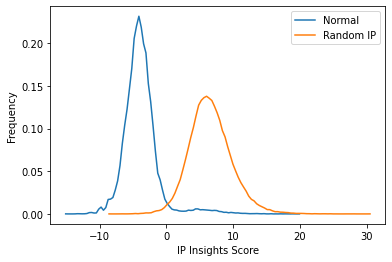

<Figure size 432x288 with 0 Axes>

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

n, x = np.histogram(test_case_scores[:NUM_SAMPLES], bins=100, density=True)
plt.plot(x[1:], n)

n, x = np.histogram(test_case_scores[NUM_SAMPLES:], bins=100, density=True)
plt.plot(x[1:], n)

plt.legend(["Normal", "Random IP"])
plt.xlabel("IP Insights Score")
plt.ylabel("Frequency")

plt.figure()

In [71]:
threshold = 0.0

flagged_cases = test_case[np.array(test_case_scores) > threshold]

num_flagged_cases = len(flagged_cases)
num_true_positives = len(flagged_cases[flagged_cases["label"] == 1])
num_false_positives = len(flagged_cases[flagged_cases["label"] == 0])
num_all_positives = len(test_case.loc[test_case["label"] == 1])

print(f"When threshold is set to: {threshold}")
print(f"Total of {num_flagged_cases} flagged cases")
print(f"Total of {num_true_positives} flagged cases are true positives")
print(f"True Positive Rate: {num_true_positives / float(num_flagged_cases)}")
print(f"Recall: {num_true_positives / float(num_all_positives)}")
print(f"Precision: {num_true_positives / float(num_flagged_cases)}")

When threshold is set to: 0.0
Total of 102797 flagged cases
Total of 98520 flagged cases are true positives
True Positive Rate: 0.9583937274434079
Recall: 0.9852
Precision: 0.9583937274434079


## Making Reference

In [21]:
l = len(test_df)

In [24]:
step = 40000
results = []
for i in range(8):
    end = min((i+1)*step, l)
    print(end)
    batch = test_df[i*step:end]
    results.extend(score_ip_insights(predictor, batch) )

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


40000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


80000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


120000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


160000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


200000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


240000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


280000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


301687


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [25]:
test_df['dot_product'] = results

### Score the malicious events

In [26]:
df_bad = pd.read_csv("sim_bad.csv")

In [29]:
df_bad.shape

(100000, 2)

In [32]:
l = len(df_bad)
step = 40000
results = []
for i in range(3):
    end = min((i+1)*step, l)
    print(end)
    batch = df_bad[i*step:end]
    results.extend(score_ip_insights(predictor, batch) )

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


40000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


80000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


100000


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [31]:
len(results)

100000

<Figure size 432x288 with 0 Axes>

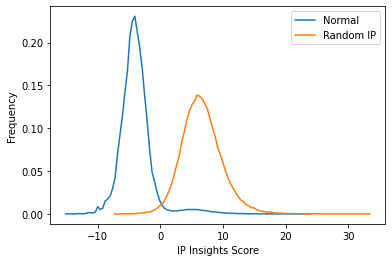

<Figure size 432x288 with 0 Axes>

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

n, x = np.histogram(test_df['dot_product'] , bins=100, density=True)
plt.plot(x[1:], n)

n, x = np.histogram(results, bins=100, density=True)
plt.plot(x[1:], n)

plt.legend(["Normal", "Random IP"])
plt.xlabel("IP Insights Score")
plt.ylabel("Frequency")

plt.figure()

In [35]:
sum(test_df['dot_product'] > 0)

12939

In [36]:
12939/len(test_df) # Type I error

0.04288882185841617

In [38]:
sum([x<0 for x in results ])/100000 # Type II error

0.0146

### Stop and Delete the Endpoint
If you are done with this model, then we should delete the endpoint before we close the notebook. Or else you will continue to pay for the endpoint while it is running. 

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [39]:
# ip_insights_tuner.delete_endpoint()
sagemaker.Session().delete_endpoint(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
